# Data Import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def get_model(state_dict):
    layers = []
    for key in state_dict.keys():
        if 'weight' in key:
            in_features = state_dict[key].shape[1]
            out_features = state_dict[key].shape[0]
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU())
    layers = layers[:-1] #Remove last ReLU
    return nn.Sequential(*layers)

def map_keys(state_dict):
    new_state_dict = {}
    layer_idx = 0
    for key in state_dict.keys():
        if 'weight' in key or 'bias' in key:
            new_key = f"{layer_idx}.{key.split('.')[-1]}"
            new_state_dict[new_key] = state_dict[key]
            if 'bias' in key:
                layer_idx += 2  # Increment for each Linear + ReLU
    return new_state_dict

class Autoencoder(nn.Module):
    def __init__(self, feature_dim, encoded_dim, linear=True):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 2),
            *([nn.ReLU()] if not linear else []),
            nn.Linear(feature_dim // 2, encoded_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoded_dim, feature_dim // 2),
            *([nn.ReLU()] if not linear else []),
            nn.Linear(feature_dim // 2, feature_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

class LoadedFeatureModel(nn.Module):
    def __init__(self, state_dict=None, linear=True):
        super(LoadedFeatureModel, self).__init__()

        if state_dict is not None:
            self.load_from_state_dict(state_dict, linear)
        else:
            raise ValueError("state_dict must be provided")

    def load_from_state_dict(self, state_dict, linear=True):
        # Load input_dim from the first layer's weight shape
        input_key = next(key for key in state_dict.keys() if 'weight' in key)
        self.input_dim = state_dict[input_key].shape[1]

        # Load output_dim from the last layer's weight shape
        output_key = [key for key in state_dict.keys() if 'weight' in key][-1]
        self.output_dim = state_dict[output_key].shape[0]

        # Count num_features from hidden layers, ignoring input and output dimensions
        weight_keys = [key for key in state_dict.keys() if 'weight' in key]
        self.num_features = sum(state_dict[key].shape[0] for key in weight_keys[1:])

        # Load the state dict into the model
        self.model = self.get_model(state_dict, linear)

    def get_model(self, state_dict, linear=True):
        self.layer_dims = [self.input_dim]
        layers = []
        for key in state_dict.keys():
            if 'weight' in key:
                in_features = state_dict[key].shape[1]
                out_features = state_dict[key].shape[0]
                self.layer_dims.append(out_features)
                layers.append(nn.Linear(in_features, out_features))
                if not linear:
                    layers.append(nn.ReLU())
        if not linear:
            layers = layers[:-1] # Remove last ReLU
        return nn.Sequential(*layers)

    def forward(self, x):
        activations = []
        activations.append(x) # View input as activation
        for layer in self.model:
            x = layer(x)
            if isinstance(layer, nn.Linear):
                activations.append(x)
        return activations

    def get_output(self, activations):
        return activations[-1]

    def get_dims(self):
        return self.layer_dims

    def get_feature_activations(self, activations):
        selected_activations = []
        for layer_activations in activations[1:-1]:
            if layer_activations.dim() == 1:
                selected_activations.append(layer_activations)
            else:
                selected_activations.append(layer_activations[0])
        return torch.cat(selected_activations)

    def get_seed(self, target_features, steps=1000, lr=0.01):
        input_dim = self.layer_dims[0]
        input_vector = torch.randn(input_dim, requires_grad=True)  # Start with a random input vector

        optimizer = optim.Adam([input_vector], lr=lr)
        criterion = nn.MSELoss()
        approximate = False

        for _ in range(steps):  # Number of optimization steps
            optimizer.zero_grad()
            activations = self.forward(input_vector.unsqueeze(0))
            selected_activations = self.get_feature_activations(activations)
            loss = criterion(selected_activations, torch.tensor(target_features, dtype=torch.float32))
            loss.backward()
            optimizer.step()

        # Check if the result is approximate
        final_activations = self.get_feature_activations(self.forward(input_vector.unsqueeze(0)))
        if not torch.allclose(final_activations, torch.tensor(target_features, dtype=torch.float32), atol=1e-2):
            approximate = True

        return input_vector.detach().numpy(), approximate

state_dict = torch.load('NL-2_feature_model.pth', map_location="cpu")
features = 64
input_dim = 10
output_dim = 2
state_dict = map_keys(state_dict)
feature_model = LoadedFeatureModel(state_dict, linear=False)
state_dict = torch.load('NL-2_encoder.pth', map_location="cpu")
autoencoder = Autoencoder(features, input_dim, linear=False)
autoencoder.load_state_dict(state_dict)
X,Y = torch.load('NL-2_data.pth')

<ipython-input-29-e8d97ff37c14>:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('NL-0_feature_model.pth', map_location="cpu")
<ipython-input-29-e8

# Measuring Polysemanticity

In [ ]:
!pip install captum

In [ ]:
import torch
import numpy as np
from captum.attr import IntegratedGradients

def get_neuron_gradients(features, encoding_model, specimen_model, layer_types=[torch.nn.Linear]):
    def get_all_activations(model, input_tensor):
        activations = []
        def hook(module, input, output):
            activations.append(output)
        hooks = []
        layers = [layer for layer in model.modules() if isinstance(layer, tuple(layer_types))]
        # Register hooks only for hidden layers (excluding input and output layer)
        for layer in layers[:-1]:
            hooks.append(layer.register_forward_hook(hook))
        model(input_tensor)
        for h in hooks:
            h.remove()
        return torch.cat([a.view(a.size(0), -1) for a in activations], dim=1)

    class CombinedModel(torch.nn.Module):
        def __init__(self, encoding_model, specimen_model):
            super().__init__()
            self.encoding_model = encoding_model
            self.specimen_model = specimen_model

        def forward(self, x):
            intermediate_output = encoding_model.encoder(x)
            specimen_activations = get_all_activations(specimen_model, intermediate_output)
            return specimen_activations

    combined_model = CombinedModel(encoding_model, specimen_model)

    baseline = torch.zeros(1, features, requires_grad=True)
    baseline_activations = combined_model(baseline)

    gradients = []
    for i in range(baseline_activations.size(1)):
        grad = []
        for f in range(features):
            input_vector = torch.zeros(1, features, requires_grad=True)
            with torch.no_grad():
                input_vector[0, f] = 1

            ig = IntegratedGradients(combined_model)
            attributions = ig.attribute(
                                input_vector,
                                target=i,
                                baselines=baseline,
                                n_steps=50,
                                method='riemann_right')
            grad.append(attributions[0,f].item())

        gradients.append(torch.tensor(grad).squeeze(0))

    gradients = torch.stack(gradients)

    return gradients.detach().numpy()

In [ ]:
def measure_relative_polysemanticity(neuron_gradients):
    polysemanticity = []
    for gradient in neuron_gradients:
        total_gradient = np.sum(np.abs(gradient))  # Sum of non-negative gradients
        max_gradient = np.max(np.abs(gradient))  # Largest gradient
        if max_gradient > 0:
            polysemanticity_value = total_gradient / max_gradient
        else:
            polysemanticity_value = 0  # Avoid division by zero
        polysemanticity.append(polysemanticity_value)
    return np.array(polysemanticity)

In [ ]:
import matplotlib.pyplot as plt

def visualize_polysemanticity(neuron_gradients, sorted=True, measure_polysemanticity = measure_relative_polysemanticity):
    polysemanticity = measure_polysemanticity(neuron_gradients)
    if sorted:
        sorted_indices = np.argsort(polysemanticity)
        polysemanticity = polysemanticity[sorted_indices]

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(polysemanticity)), polysemanticity)
    plt.title("Polysemanticity per Neuron")
    plt.xlabel("Sorted Neuron Index" if sorted else "Neuron Index")
    plt.ylabel("Polysemanticity")

    # Set y-axis to show only integer values
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))

    plt.tight_layout()
    plt.grid()
    plt.show()

In [ ]:
def visualize_layerwise_polysemanticity(neuron_gradients, measure_polysemanticity = measure_relative_polysemanticity):
    polysemanticity = measure_polysemanticity(neuron_gradients)
    layer_dims = []
    layer_means = []
    current_index = 0

    # Extract hidden layer dimensions
    layers = [layer for layer in model.modules() if isinstance(layer, nn.Linear)]
    for layer in layers[:-1]:
        out_features = layer.out_features
        layer_dims.append(out_features)
        layer_mean = np.mean(polysemanticity[current_index:current_index+out_features])
        layer_means.append(layer_mean)
        current_index += out_features
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(layer_means)), layer_means)
    plt.xlabel('Layer')
    plt.ylabel('Mean Polysemanticity')
    plt.title('Layer-wise Mean Polysemanticity')
    plt.xticks(range(len(layer_means)), [f'Layer {i+1}\n({dim} neurons)' for i, dim in enumerate(layer_dims)])
    plt.tight_layout()
    plt.show()

def get_layerwise_polysemanticity(neuron_gradients, measure_polysemanticity = measure_relative_polysemanticity):
    polysemanticity = measure_polysemanticity(neuron_gradients)
    layer_means = []
    current_index = 0

    # Extract hidden layer dimensions
    layers = [layer for layer in model.modules() if isinstance(layer, nn.Linear)]
    for layer in layers[:-1]:
        out_features = layer.out_features
        layer_mean = np.mean(polysemanticity[current_index:current_index+out_features])
        layer_means.append(layer_mean)
        current_index += out_features

    return layer_means

In [ ]:
def calculate_feature_dimensionality(neuron_gradients):
    total_neurons, total_features = neuron_gradients.shape
    neuron_gradients = torch.tensor(neuron_gradients)

    # Calculate feature dimensionality for each neuron
    abs_gradients = torch.abs(neuron_gradients)
    sum_abs_gradients = torch.sum(abs_gradients, dim=1, keepdim=True)
    feature_contributions = abs_gradients / sum_abs_gradients

    # Sum feature contributions across all neurons
    total_feature_dimensionality = torch.sum(feature_contributions, dim=0)

    # Clip values to a maximum of 1
    total_feature_dimensionality = torch.clamp(total_feature_dimensionality, max=1.0)

    # Calculate the final result
    result = torch.sum(total_feature_dimensionality) / total_features

    return result.item()

# Baseline Model (Construction, Training, Evaluation)

Epoch [10/50], Loss: 0.1763
Epoch [20/50], Loss: 0.0907
Epoch [30/50], Loss: 0.1332
Epoch [40/50], Loss: 0.1209
Epoch [50/50], Loss: 0.0949
0.9780632257461548
7.9007087


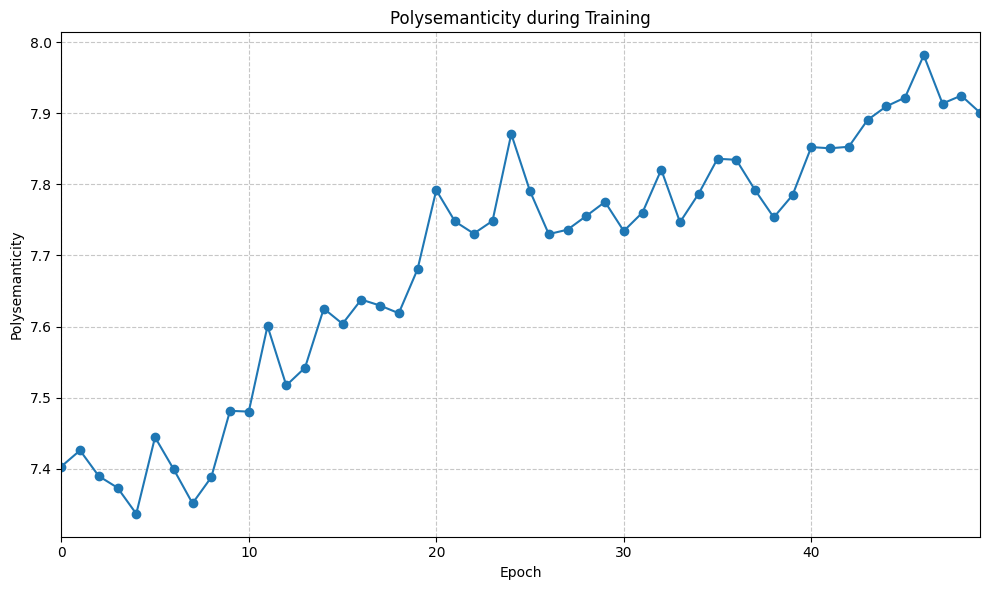

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model and move it to the appropriate device
model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        ).to(device)

# Prepare the dataset
X = X.to(device)
Y = Y.to(device)
dataset = TensorDataset(X, Y)

# Split the data into training (70%) and testing (30%) sets
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
train_polys = []
train_dims = []
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()
    gradients = get_neuron_gradients(features, autoencoder, model)
    train_dims.append(calculate_feature_dimensionality(gradients))
    train_polys.append(np.mean(measure_relative_polysemanticity(gradients)))
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()

# Collect all predictions and targets
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        all_preds.append(outputs)
        all_targets.append(targets)

# Concatenate all predictions and targets
all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# MSE test loss
losses = [criterion(all_preds, all_targets)]

gradients = get_neuron_gradients(features, autoencoder, model)
print(calculate_feature_dimensionality(gradients))
print(np.mean(measure_relative_polysemanticity(gradients)))

dimensionalities = [calculate_feature_dimensionality(gradients)]
polysemanticities = [np.mean(measure_relative_polysemanticity(gradients))]

baseline_model = nn.Sequential(
        nn.Linear(input_dim, 256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, output_dim)
    ).to(device)
baseline_model.load_state_dict(model.state_dict())


import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_polys, marker='o')

# Set labels and title
plt.xlabel('Epoch')
plt.ylabel('Polysemanticity')
plt.title('Polysemanticity during Training')

plt.xlim(0, num_epochs - 1)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

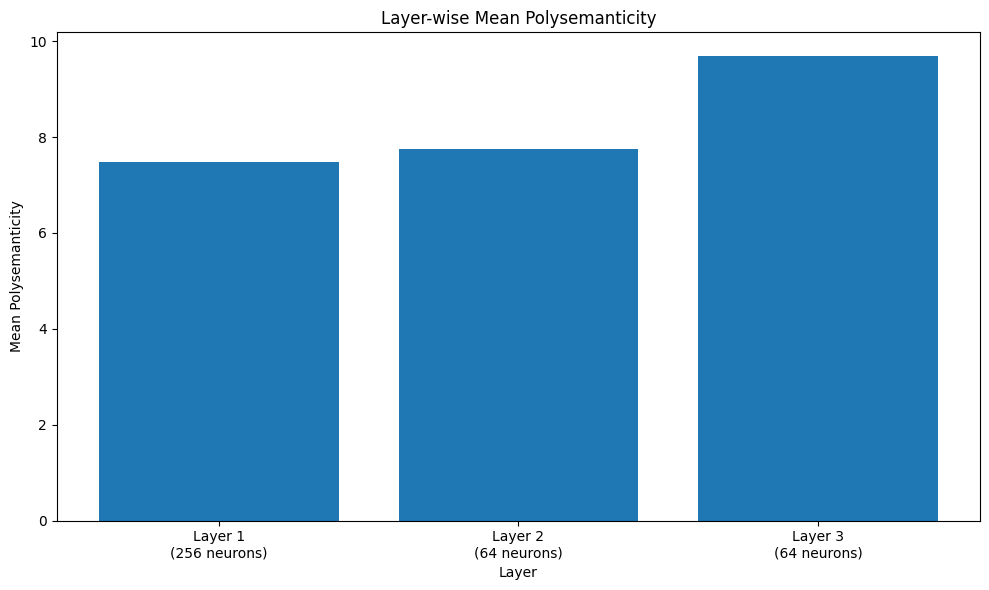

In [ ]:
visualize_layerwise_polysemanticity(gradients)

# Pruning (incl. Retraining and Evaluation)

In [ ]:
!pip install torch-pruning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.9/62.9 kB 2.9 MB/s eta 0:00:00


In [ ]:
import torch_pruning as tp

class GlobalMagnitudeImportance(tp.importance.Importance):
    def __call__(self, group):
        importance = []
        for dep, _ in group:
            if isinstance(dep.target.module, nn.Linear):
                weights = dep.target.module.weight.data
                importance.append(weights.abs().mean(dim=1))
        return torch.cat(importance) if importance else torch.tensor([0.0])

class GlobalMagnitudePruner(tp.pruner.MetaPruner):
    def __init__(self, model, example_inputs, importance, pruning_ratio, **kwargs):
        output_layer = list(model.children())[-1]

        # Add output layer to ignored_layers
        if 'ignored_layers' not in kwargs:
            kwargs['ignored_layers'] = []
        kwargs['ignored_layers'].extend([output_layer])

        super().__init__(
            model,
            example_inputs,
            importance,
            global_pruning=True,
            pruning_ratio = pruning_ratio,
            **kwargs
        )

In [ ]:
def prune(model, ratio, example_inputs, epochs):
    importance = GlobalMagnitudeImportance()

    pruner = GlobalMagnitudePruner(
        model,
        example_inputs,
        importance,
        pruning_ratio=ratio
    )

    # Perform pruning
    pruner.step()
    _, nparams = tp.utils.count_ops_and_params(model, example_inputs)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(epochs):
        model.train()
        pruner.update_regularizer() # <== initialize regularizer
        for i, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, target)
            loss.backward() # after loss.backward()
            pruner.regularize(model, loss=loss) # <== for sparse training
            optimizer.step() # before optimizer.step()

    return nparams

model = nn.Sequential(
        nn.Linear(input_dim, 256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, output_dim)
    ).to(device)
model.load_state_dict(baseline_model.state_dict())
ratios = [0]
example_inputs = next(iter(train_loader))[0]
_, base_nparams = tp.utils.count_ops_and_params(baseline_model, example_inputs)
for i in np.arange(0.05, 0.65, 0.05):
    model = nn.Sequential(
        nn.Linear(input_dim, 256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, output_dim)
    ).to(device)
    model.load_state_dict(baseline_model.state_dict())
    ratio = 1-prune(model, i, example_inputs, 50)/base_nparams
    ratios.append(ratio)
    gradients = get_neuron_gradients(features, autoencoder, model)
    dimensionalities.append(calculate_feature_dimensionality(gradients))
    polysemanticities.append(np.mean(measure_relative_polysemanticity(gradients)))
    # Evaluation
    model.eval()

    # Collect all predictions and targets
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            outputs = model(inputs)
            all_preds.append(outputs)
            all_targets.append(targets)

    # Concatenate all predictions and targets
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # MSE train loss
    losses.append(criterion(all_preds, all_targets))

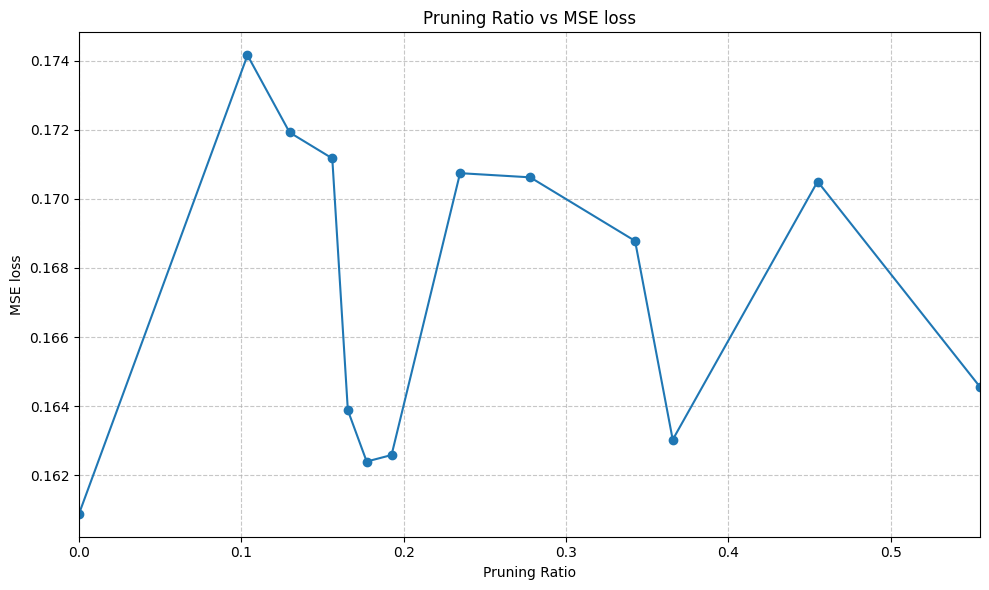

In [ ]:
# Sort the data based on ratios
sorted_data = sorted(zip(ratios, losses))
ratios_sorted, losses_sorted = zip(*sorted_data)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(ratios_sorted, losses_sorted, marker='o')

# Set labels and title
plt.xlabel('Pruning Ratio')
plt.ylabel('MSE loss')
plt.title('Pruning Ratio vs MSE loss')

plt.xlim(0, ratios_sorted[-1])

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

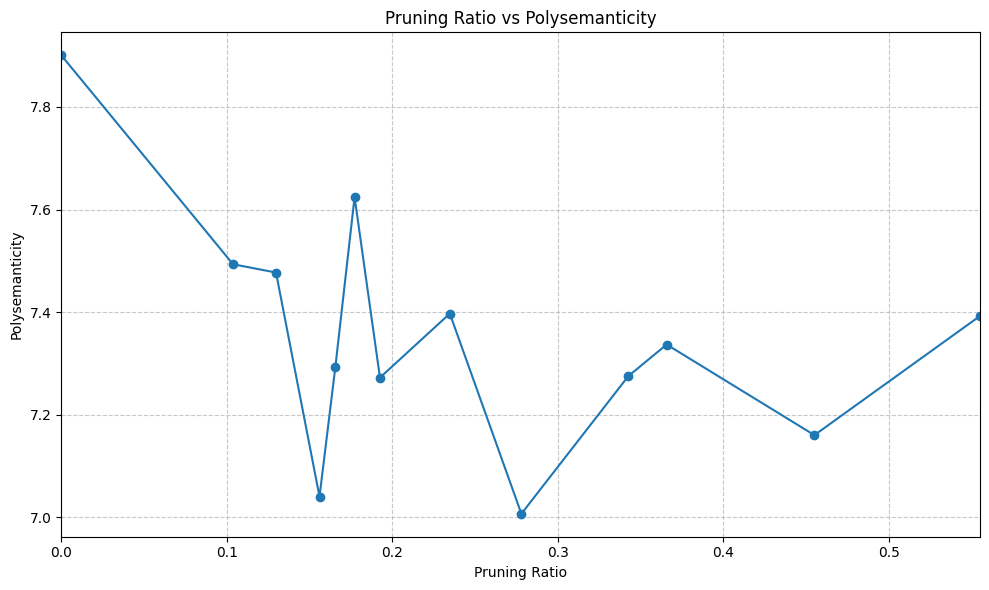

In [ ]:
import matplotlib.pyplot as plt

# Sort the data based on ratios
sorted_data = sorted(zip(ratios, polysemanticities, dimensionalities))
ratios_sorted, polysemanticities_sorted, dimensionalities_sorted = zip(*sorted_data)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(ratios_sorted, polysemanticities_sorted, marker='o')

# Annotate each point with its dimensionality
# for x, y, dim in zip(ratios_sorted, polysemanticities_sorted, dimensionalities_sorted):
#     plt.annotate(f'{dim:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Set labels and title
plt.xlabel('Pruning Ratio')
plt.ylabel('Polysemanticity')
plt.title('Pruning Ratio vs Polysemanticity')

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.xlim(0, ratios_sorted[-1])

# Show the plot
plt.tight_layout()
plt.show()

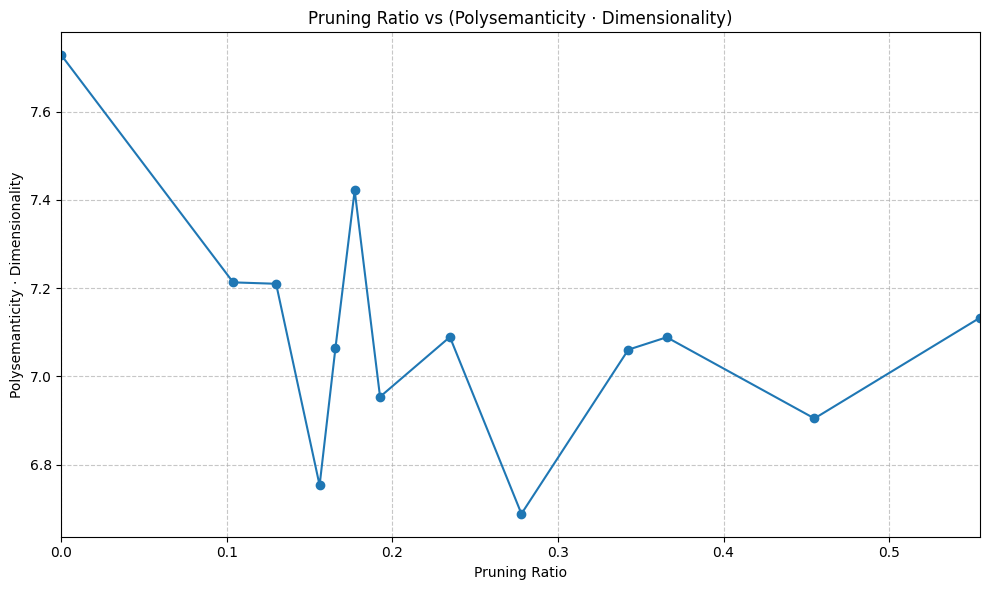

In [ ]:
import matplotlib.pyplot as plt

y_values = [d * p for d, p in zip(dimensionalities, polysemanticities)]

# Sort the data based on ratios
sorted_data = sorted(zip(ratios, y_values))
ratios_sorted, y_values_sorted = zip(*sorted_data)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(ratios_sorted, y_values_sorted, marker='o')

# Set labels and title
plt.xlabel('Pruning Ratio')
plt.ylabel('Polysemanticity ⋅ Dimensionality')
plt.title('Pruning Ratio vs (Polysemanticity ⋅ Dimensionality)')

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.xlim(0, ratios_sorted[-1])

# Show the plot
plt.tight_layout()
plt.show()

[(7.007185, tensor(0.1706)), (7.040695, tensor(0.1712)), (7.16048, tensor(0.1705)), (7.2724996, tensor(0.1626)), (7.275342, tensor(0.1688)), (7.2938867, tensor(0.1639)), (7.3370514, tensor(0.1630)), (7.3926706, tensor(0.1646)), (7.397312, tensor(0.1707)), (7.4773474, tensor(0.1719)), (7.4934278, tensor(0.1742)), (7.624446, tensor(0.1624)), (7.9007087, tensor(0.1609))]


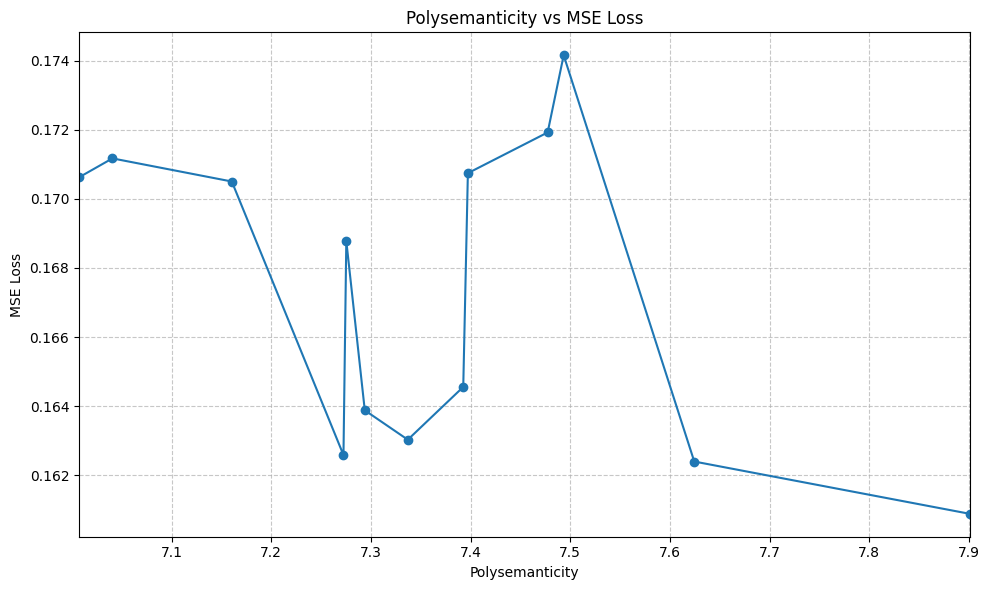

In [ ]:
import matplotlib.pyplot as plt

# Sort the data based on ratios
sorted_data = sorted(zip(polysemanticities, losses))
poly_sorted, losses_sorted = zip(*sorted_data)
print(sorted_data)
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(poly_sorted, losses_sorted, marker='o')

# Set labels and title
plt.xlabel('Polysemanticity')
plt.ylabel('MSE Loss')
plt.title('Polysemanticity vs MSE Loss')

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.xlim(poly_sorted[0], poly_sorted[-1])

# Show the plot
plt.tight_layout()
plt.show()

# Dropout

Epoch [10/50], Loss: 0.1282
Epoch [20/50], Loss: 0.0999
Epoch [30/50], Loss: 0.1709
Epoch [40/50], Loss: 0.2355
Epoch [50/50], Loss: 0.1183
0.9724937677383423
6.1635566


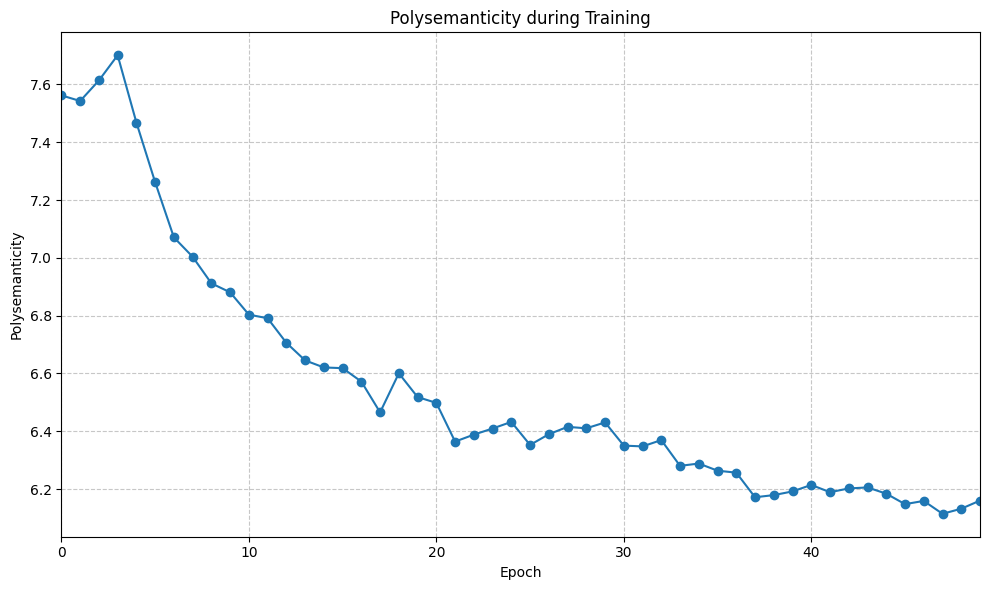

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model and move it to the appropriate device
model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, output_dim)
        ).to(device)

# Prepare the dataset
X = X.to(device)
Y = Y.to(device)
dataset = TensorDataset(X, Y)

# Split the data into training (70%) and testing (30%) sets
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
d_train_polys = []
train_dims = []
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()
    gradients = get_neuron_gradients(features, autoencoder, model)
    train_dims.append(calculate_feature_dimensionality(gradients))
    d_train_polys.append(np.mean(measure_relative_polysemanticity(gradients)))
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()

# Collect all predictions and targets
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        all_preds.append(outputs)
        all_targets.append(targets)

# Concatenate all predictions and targets
all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# MSE train loss
d_losses = [criterion(all_preds, all_targets)]

gradients = get_neuron_gradients(features, autoencoder, model)
print(calculate_feature_dimensionality(gradients))
print(np.mean(measure_relative_polysemanticity(gradients)))

dimensionalities = [calculate_feature_dimensionality(gradients)]
d_polysemanticities = [np.mean(measure_relative_polysemanticity(gradients))]

baseline_model = nn.Sequential(
        nn.Linear(input_dim, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, output_dim)
    ).to(device)
baseline_model.load_state_dict(model.state_dict())


import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), d_train_polys, marker='o')

# Set labels and title
plt.xlabel('Epoch')
plt.ylabel('Polysemanticity')
plt.title('Polysemanticity during Training')

plt.xlim(0, num_epochs - 1)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
model = nn.Sequential(
        nn.Linear(input_dim, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, output_dim)
    ).to(device)
model.load_state_dict(baseline_model.state_dict())
ratios = [0]
example_inputs = next(iter(train_loader))[0]
_, base_nparams = tp.utils.count_ops_and_params(baseline_model, example_inputs)
for i in np.arange(0.05, 0.65, 0.05):
    model = nn.Sequential(
        nn.Linear(input_dim, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, output_dim)
    ).to(device)
    model.load_state_dict(baseline_model.state_dict())
    ratio = 1-prune(model, i, example_inputs, 50)/base_nparams
    ratios.append(ratio)
    gradients = get_neuron_gradients(features, autoencoder, model)
    dimensionalities.append(calculate_feature_dimensionality(gradients))
    d_polysemanticities.append(np.mean(measure_relative_polysemanticity(gradients)))
    # Evaluation
    model.eval()

    # Collect all predictions and targets
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            outputs = model(inputs)
            all_preds.append(outputs)
            all_targets.append(targets)

    # Concatenate all predictions and targets
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # MSE train loss
    d_losses.append(criterion(all_preds, all_targets))

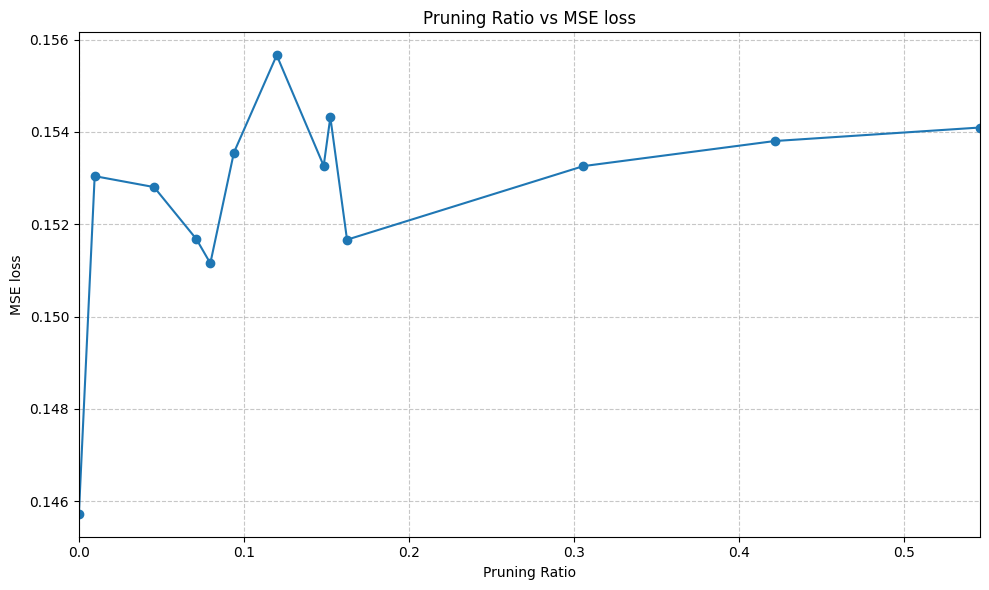

In [ ]:
# Sort the data based on ratios
sorted_data = sorted(zip(ratios, d_losses))
ratios_sorted, losses_sorted = zip(*sorted_data)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(ratios_sorted, losses_sorted, marker='o')

# Set labels and title
plt.xlabel('Pruning Ratio')
plt.ylabel('MSE loss')
plt.title('Pruning Ratio vs MSE loss')

plt.xlim(0, ratios_sorted[-1])

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

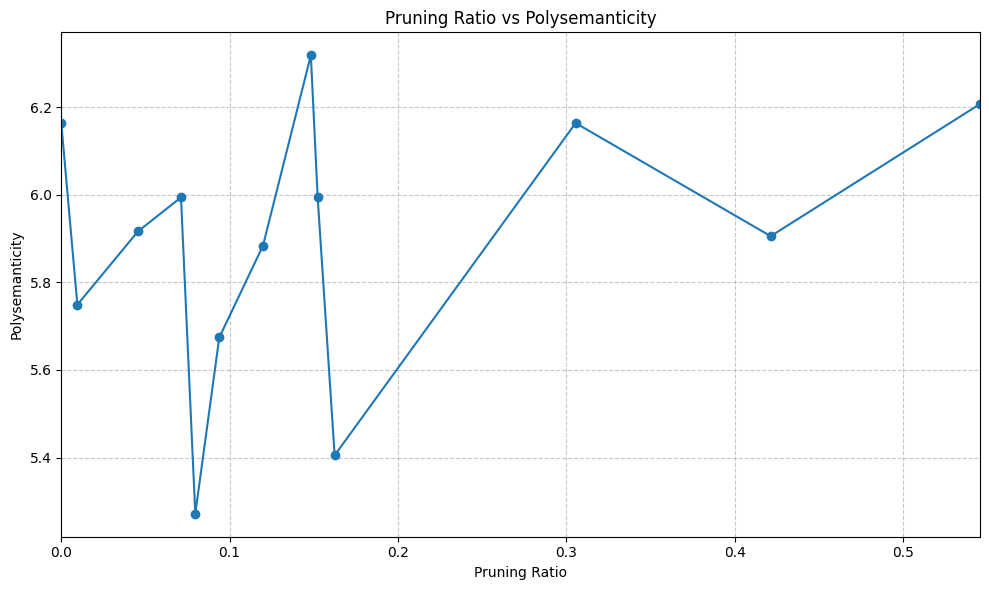

In [ ]:
import matplotlib.pyplot as plt

# Sort the data based on ratios
sorted_data = sorted(zip(ratios, d_polysemanticities, dimensionalities))
ratios_sorted, polysemanticities_sorted, dimensionalities_sorted = zip(*sorted_data)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(ratios_sorted, polysemanticities_sorted, marker='o')

# Annotate each point with its dimensionality
# for x, y, dim in zip(ratios_sorted, polysemanticities_sorted, dimensionalities_sorted):
#     plt.annotate(f'{dim:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Set labels and title
plt.xlabel('Pruning Ratio')
plt.ylabel('Polysemanticity')
plt.title('Pruning Ratio vs Polysemanticity')

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.xlim(0, ratios_sorted[-1])

# Show the plot
plt.tight_layout()
plt.show()

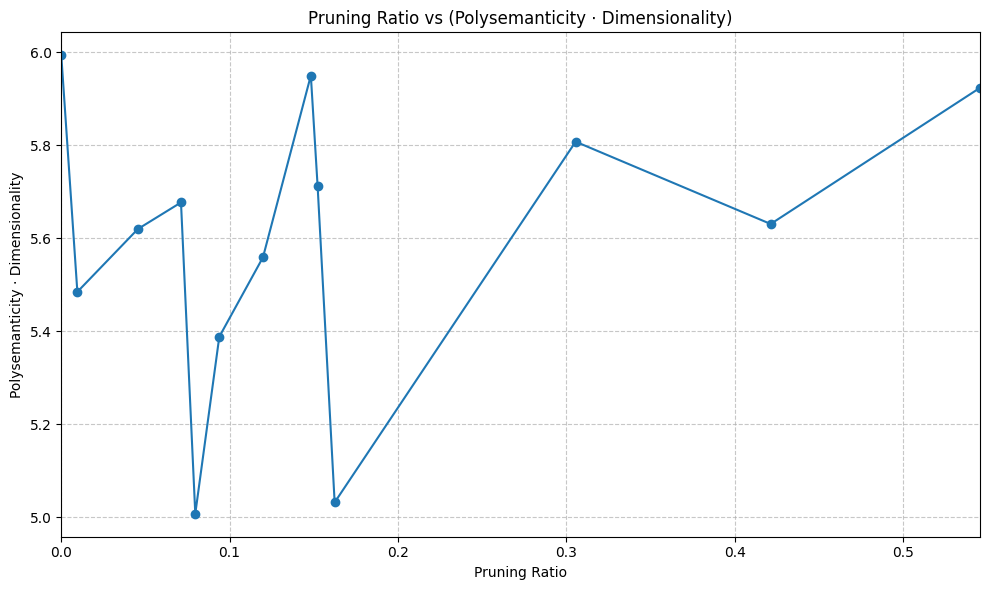

In [ ]:
import matplotlib.pyplot as plt

y_values = [d * p for d, p in zip(dimensionalities, d_polysemanticities)]

# Sort the data based on ratios
sorted_data = sorted(zip(ratios, y_values))
ratios_sorted, y_values_sorted = zip(*sorted_data)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(ratios_sorted, y_values_sorted, marker='o')

# Set labels and title
plt.xlabel('Pruning Ratio')
plt.ylabel('Polysemanticity ⋅ Dimensionality')
plt.title('Pruning Ratio vs (Polysemanticity ⋅ Dimensionality)')

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.xlim(0, ratios_sorted[-1])

# Show the plot
plt.tight_layout()
plt.show()

[(5.271572, tensor(0.1512)), (5.4051285, tensor(0.1517)), (5.6742554, tensor(0.1536)), (5.748972, tensor(0.1530)), (5.883743, tensor(0.1557)), (5.9056096, tensor(0.1538)), (5.9163733, tensor(0.1528)), (5.994106, tensor(0.1517)), (5.9954586, tensor(0.1543)), (6.1635566, tensor(0.1457)), (6.1638923, tensor(0.1533)), (6.2073617, tensor(0.1541)), (6.3187327, tensor(0.1533))]


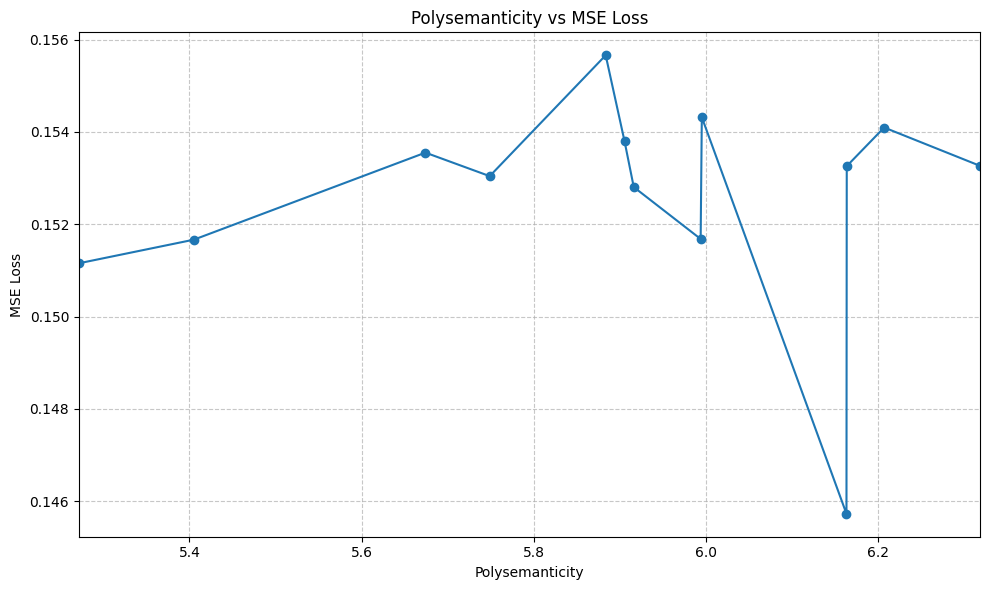

In [ ]:
import matplotlib.pyplot as plt

# Sort the data based on ratios
sorted_data = sorted(zip(d_polysemanticities, d_losses))
poly_sorted, losses_sorted = zip(*sorted_data)
print(sorted_data)
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(poly_sorted, losses_sorted, marker='o')

# Set labels and title
plt.xlabel('Polysemanticity')
plt.ylabel('MSE Loss')
plt.title('Polysemanticity vs MSE Loss')

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.xlim(poly_sorted[0], poly_sorted[-1])

# Show the plot
plt.tight_layout()
plt.show()

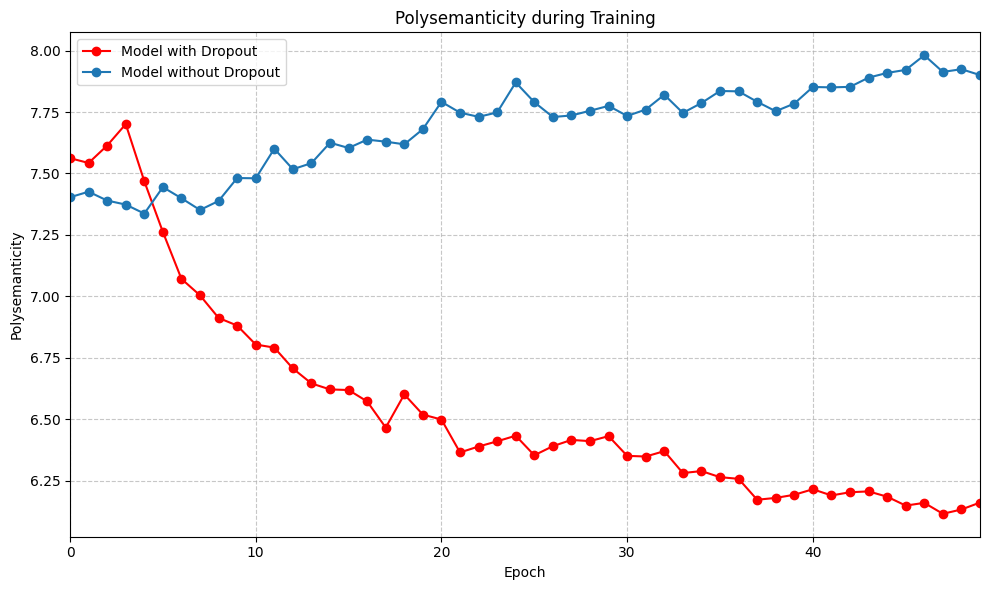

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), d_train_polys, marker='o', color="red", label="Model with Dropout")
plt.plot(range(num_epochs), train_polys, marker='o', label="Model without Dropout")

# Set labels and title
plt.xlabel('Epoch')
plt.ylabel('Polysemanticity')
plt.title('Polysemanticity during Training')

plt.xlim(0, num_epochs - 1)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

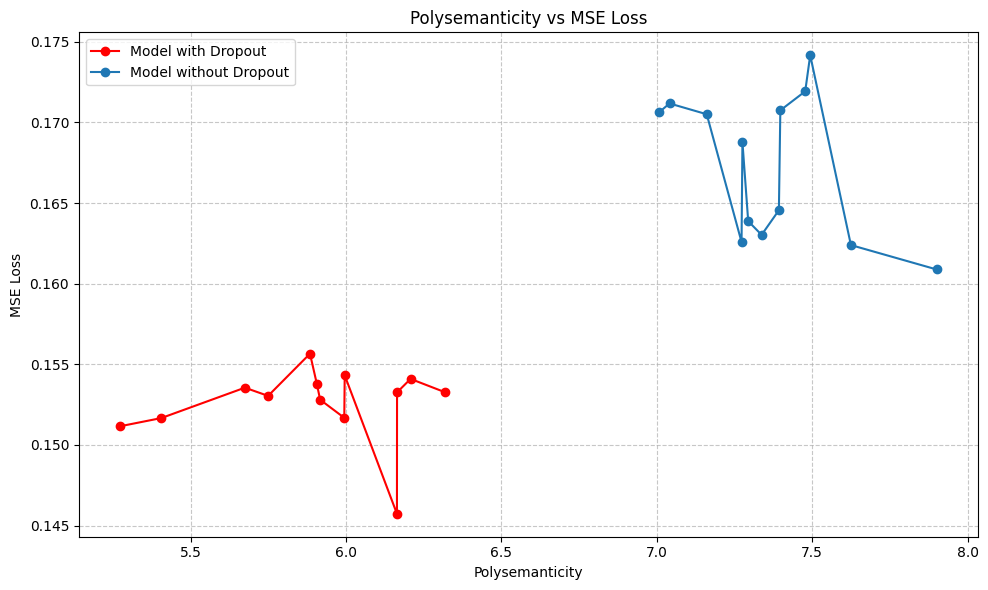

In [ ]:
sorted_data = sorted(zip(d_polysemanticities, d_losses))
d_poly_sorted, d_losses_sorted = zip(*sorted_data)

sorted_data = sorted(zip(polysemanticities, losses))
poly_sorted, losses_sorted = zip(*sorted_data)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(d_poly_sorted, d_losses_sorted, marker='o', color="red", label="Model with Dropout")
plt.plot(poly_sorted, losses_sorted, marker='o', label="Model without Dropout")

# Set labels and title
plt.xlabel('Polysemanticity')
plt.ylabel('MSE Loss')
plt.title('Polysemanticity vs MSE Loss')

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()